# Text to speech using Tacotron2

## Topic

In this notebook I will experiment with speech synthesis from text using Tacotron2 which is a deep neural network that uses sequence to sequence architecture and which produces a mel spectromgram out of a text and then converts it to audio using Vocoder. After extracting the audio I will then use a series of audio augmentation techniques to make the sound more natural. So let's get started !

## Objectives

- Convert text to audio
- Use audio augmentation to enhance the extracted audio

## Summary

- Importing libraries
- Text to speech
- Adding white noise
- Time stretching
- Pitch scaling
- Inverting polarity
- Random gain
- Conclusion

### Importing libraries

In [26]:
import torchaudio
from IPython.display import Audio, display
import IPython
import numpy as np
from logmmse import logmmse
import torch
import matplotlib.pyplot as plt
import random
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import scipy.io.wavfile as wavf
import struct 
import librosa
import soundfile
import pandas as pd

### Text to Speech

In [2]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2()
vocoder = bundle.get_vocoder()

In [3]:
text = "Artificial intelligence is the simulation of human intelligence processes by machines,"

In [4]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return Audio(waveforms[0:1], rate=sample_rate)


In [5]:
def text2speech(text, path):
    inputs, lengths = processor(text)
    specgram, lengths, _ = tacotron2.infer(inputs, lengths)
    waveforms, lengths = vocoder(specgram, lengths)
    plot(waveforms, specgram, vocoder.sample_rate)
    torchaudio.save(path, waveforms, vocoder.sample_rate)

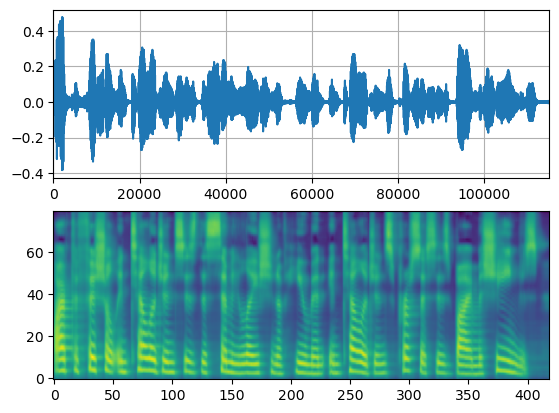

In [6]:
text2speech(text, "exp_1.wav")

In [8]:
IPython.display.Audio("exp_1.wav")

In this first part I created and used a function that takes in a typed text, encodes the text into digits, produces a mel spectrogram using Tacotron2.infer and then converts it to a waveform using Vocoder to finally convert it into audio. I also used a function that plots the mel spectrogram and soundwave to see how they look like. Then I finally played the audio.

In [17]:
audio_1, sample_rate = librosa.load('exp_1.wav')

### Adding white noise

In [18]:
def add_white_noise(signal, noise_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented = signal + noise*noise_factor
    return augmented

In [19]:
noised = add_white_noise(audio_1, 0.1)

In [24]:
soundfile.write("noised.wav", noised, sample_rate)

In [25]:
IPython.display.Audio("noised.wav")

<Axes: >

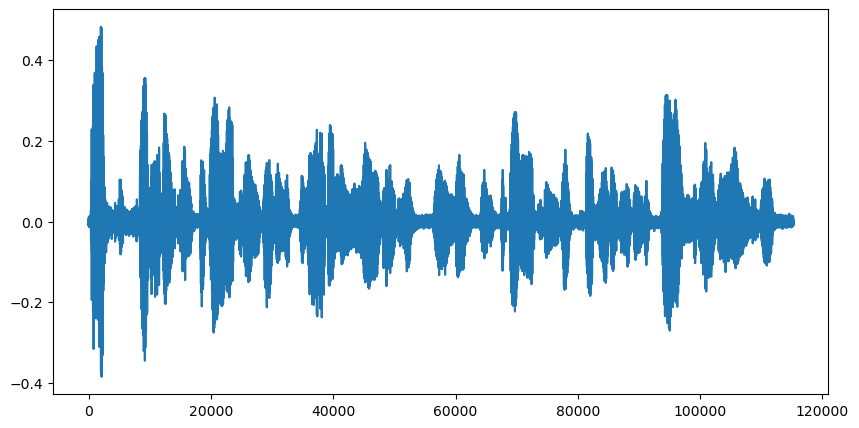

In [27]:
sv, sr = torchaudio.load("noised.wav")
sv = torch.flatten(sv)
pd.Series(sv).plot(figsize=(10,5))

The first augmentation step was to add gaussian noise (white noise) in the background of the audio, I did this with the help of numpy, then I plotted the resultant soundwave which shows that the silences have been replaced by some kind of sound. I then played the audio for reference.

### Time stretch

In [69]:
sv, sr = librosa.load('noised.wav')

In [73]:
stretched = librosa.effects.time_stretch(sv, rate = 0.7)

In [74]:
soundfile.write("stretched.wav", stretched, sr)

In [75]:
IPython.display.Audio("stretched.wav")

<Axes: >

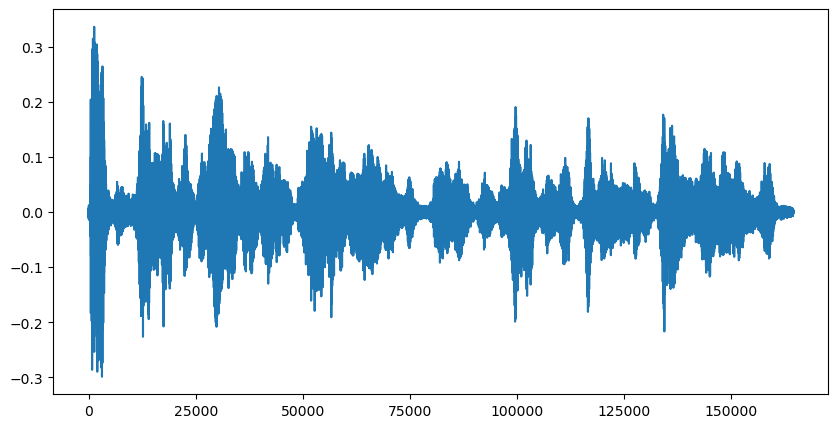

In [76]:
sv, sr = torchaudio.load("stretched.wav")
sv = torch.flatten(sv)
pd.Series(sv).plot(figsize=(10,5))

Next I did some time stretching with the help of Librosa, I basically stretched the sound to be slower than the original and the waveform plot shows in the x axis that duration of the audio has increased.

### Pitch scaling

In [97]:
sv, sr = librosa.load('stretched.wav')

In [101]:
pitch_scaled = librosa.effects.pitch_shift(sv, sr =sr, n_steps= 2)

In [102]:
soundfile.write("pitch_scaled.wav", pitch_scaled, sr)

In [103]:
IPython.display.Audio("pitch_scaled.wav")

<Axes: >

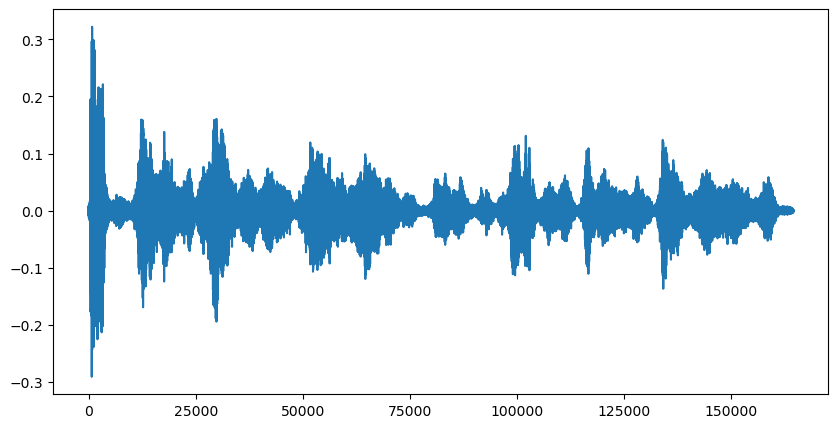

In [108]:
sv, sr = torchaudio.load("pitch_scaled.wav")
sv = torch.flatten(sv)
pd.Series(sv).plot(figsize=(10,5))

Then I scaled the pitch of the audio by increasing it a little bit which resulted in a younger sounding voice.

### Inverting polarity

In [104]:
sv, sr = librosa.load('pitch_scaled.wav')

In [105]:
inverted = sv* -1

In [106]:
soundfile.write("inverted.wav", inverted, sr)

In [107]:
IPython.display.Audio("inverted.wav")

<Axes: >

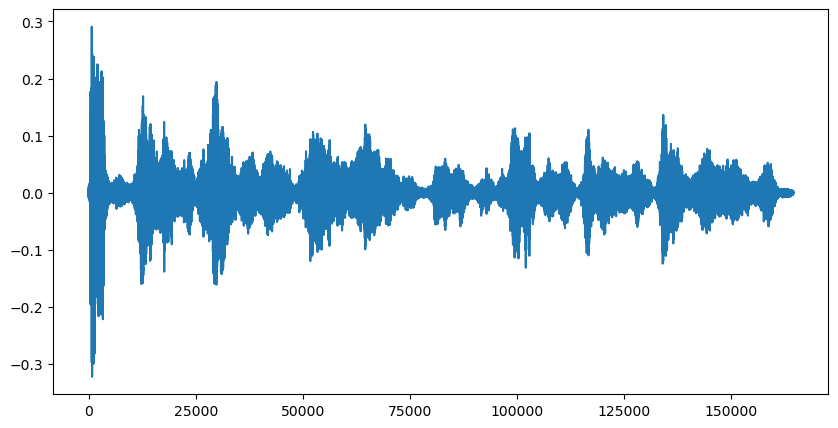

In [109]:
sv, sr = torchaudio.load("inverted.wav")
sv = torch.flatten(sv)
pd.Series(sv).plot(figsize=(10,5))

Next thing I did was to invert polarity of the audio which means swapping positive and negative voltage and that was simply done by multiplying the soundwave by -1. The changes however cannot be noticed by ear.

### Random gain

In [111]:
sv, sr = librosa.load('inverted.wav')

In [112]:
def random_gain(signal, min_gain_factor, max_gain_factor):
    gain_factor = random.uniform(min_gain_factor, max_gain_factor)
    return signal * gain_factor

In [117]:
gained = random_gain(sv, 2, 10)

In [118]:
soundfile.write("gained.wav", gained, sr)

In [119]:
IPython.display.Audio("gained.wav")

<Axes: >

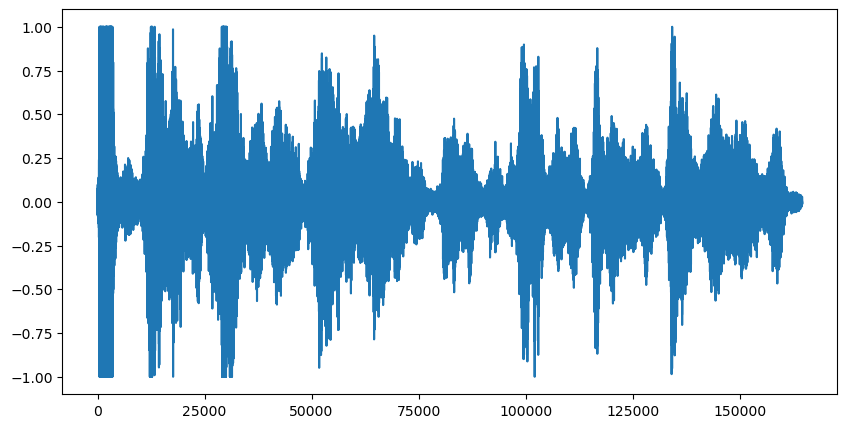

In [120]:
sv, sr = torchaudio.load("gained.wav")
sv = torch.flatten(sv)
pd.Series(sv).plot(figsize=(10,5))

Finally I used random gain to increase the quality and volume of the audio, as seen above in the resulting soundwave plot, the voice has been stratched from a range of -0.3 to 0.3 to a range of -1 to 1. The final result has more volume and emphasis on the voice.

## Conclusion

In this brief notebook I was able to generate voice from typed text using Tactron2, I then used a couple of audio augmentation techniques like adding white noise, scaling the pitch, stretching etc to try and enhance the quality of the generated audio.